# Process headers of emails

Input is the list of emails of the original corpus.

 1. Extract headers (including TO and CC) from each email, i.e. identify relevant lines
 2. Parse header lines into variable name and value
 3. Parse the values of extracted header variables (dates, email addresses)
 4. Sort emails (headers + bodies) by time sent
 5. Sort additionally into 'conversations' by grouping emails in which values of variables `id` and `inreplyto` match <br>
    -> turns out a failure: almost all 'conversations' have length 1!

In [1]:
import os
from datetime import datetime
from tqdm import tqdm
import re
import numpy as np

import html
import email.utils as mailutil

from dateutil.parser import parse as du_parse
import datetime
from datetime import timedelta

import pickle

## Read mails from files

 - already unescape HTML entities

In [2]:
mails = []
for f in tqdm(os.listdir("files")):
    with open("files/"+f) as handle:
        mails.append(list(map(html.unescape, handle.readlines())))

100%|██████████| 161645/161645 [01:15<00:00, 2129.58it/s]


## Extract headers and TO & CC

 - header lines have format var=value
 - header lines exclusively at the top of email and no more than 12
 - to & cc have format var:value; cc optional; may be mixed with lines of email body

In [3]:
header_pattern = re.compile(r"([a-z]+)=([\w\W]+)")
to_pattern = re.compile(r"[tT][oO]:([\w\W]+)")
cc_pattern = re.compile(r"[cC][cC]:([\w\W]+)")

def extract_meta(mail):
    d = {}
    mail_content = []
    for i, line in enumerate(mail):
        match_or_none = header_pattern.match(line)
        if match_or_none and i <= 11:
            k, v = match_or_none.groups()
            d[k.lower()] = v
        elif to_pattern.match(line):
            d["to"] = mailutil.parseaddr(line)
        elif cc_pattern.match(line):
            d["cc"] = mailutil.parseaddr(line)
        else:
            mail_content.append(line)
    mail_content = "".join(mail_content)
    return d, mail_content

## Parse headers

 - remove trailing new line and surrounding quotes for each header line
 - currently: use subset `sent`, `id`, `name`, `email`, `subject`, `inreplyto`, `to`, `cc`
 - parse field `sent` with `dateutil`
 - parse field `email` with `email.utils` -> ensures field's value only consists of address
 - currently: filter mail if field `to` not in header, fields `cc` and `inreplyto` optional
 - TODO:
   - re-parse output of `email.utils` to ensure that extracted address is a valid email address
 
 
 - finally, remove mails for which parsing of header fails (currently 17682 mails):
   - 2 have no field `name` in the header
   - 1524 have no field `to`
   - 11254 emails have value in field `sent` which can't be parsed by `dateutil` <br> 
     (11252 of these have issue with time zone, mainly missing `+` or `-`) 
   - 5264 emails have no parseable timezone information
   - 2 emails have timezone offsets outside of 24-hour range
   
 - leaves 143963 emails, out of the original 161645 (or 89%)

In [4]:
def prep_line(s):
    return s.strip().strip("\"").strip('\'')

def process_time_sent(s):
    dt = du_parse(s)
    
    if not dt.tzinfo:
            raise ValueError("No timezone information in parse!", s)
            dt = dt.replace(tzinfo=datetime.timezone.utc)
    if dt.tzinfo.utcoffset(dt) > timedelta(hours=24) or\
            dt.tzinfo.utcoffset(dt) < -timedelta(hours=24):
        print("Timezone outside of 24 hours: ", dt.tzinfo.utcoffset(dt))
        raise ValueError("Timezone outside of 24 hours: ", dt.tzinfo.utcoffset(dt))
    return dt
    
    

def parse_header(d):
    d = {k: prep_line(v) if type(v) is str else v for k, v in d.items()}
    new_d = {}
    try:
        new_d["sent"] = process_time_sent(d["sent"])
        new_d["id"] = d["id"]
        new_d["name"] = d["name"]
        new_d["email"] = mailutil.parseaddr(d["email"])[1]
        new_d["subject"] = d["subject"]
        new_d["inreplyto"] = d["inreplyto"] if "inreplyto" in d else None
        new_d["to"] = d["to"]
        new_d["cc"] = d["cc"] if "cc" in d else None
        return new_d
    except Exception as e:
        parse_header.errors.append(e)
        return None     
parse_header.errors=[]        

In [5]:
# do extract_meta and parse_headers in one step (otherwise RAM overflow)
parsed_gen = (extract_meta(m) for m in mails)
extracted_gen = ((parse_header(h), mc) for h, mc in parsed_gen)
headers_fltrd, mails_fltrd = list(zip(*((h, m) for h, m in tqdm(extracted_gen) if h)))

0it [00:00, ?it/s]/home/valentin/.local/lib/python3.6/site-packages/dateutil/parser/_parser.py:1206: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
129it [00:00, 338.01it/s]/home/valentin/.local/lib/python3.6/site-packages/dateutil/parser/_parser.py:1206: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/valentin/.local/lib/python3.6/site-packages/dateutil/parser/_parser.py:1206: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
311it 

Timezone outside of 24 hours:  -2 days, 17:00:00


134877it [01:10, 2123.59it/s]/home/valentin/.local/lib/python3.6/site-packages/dateutil/parser/_parser.py:1206: UnknownTimezoneWarning: tzname E identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
157813it [01:21, 2155.73it/s]

Timezone outside of 24 hours:  -2 days, 20:00:00


161645it [01:23, 1940.80it/s]


## Sort emails into conversation structure

 - first: sort by time sent (field `sent`)
 - second: group into conversations by doing for each email:
   1. if email has `inreplyto=None`, start new conversation
   2. else look up email with ID corresponding to `inreplyto` value
     - if there is no other email with the `id` that was given by `inreplyto`, also start a new conversation
     
   -> each separate list of emails is a 'conversation', i.e. all in reply to each other and in correct temporal order
   

 - sorting by time sent seems to work, original corpus was randomly ordered
 - grouping into conversations by `inreplyto` does not work well, as extracted conversations <br>
   turn out to be very short (overwhelming majority consists of a single email) <br>
   -> refrain from this for now, later steps are only sorted according to time sent 

In [6]:
headers_srtd, mails_srtd = list(zip(*sorted(zip(headers_fltrd, mails_fltrd), key=lambda t: t[0]["sent"])))

with open("headers_processed.pkl", "wb") as handle:
    pickle.dump((headers_srtd, mails_srtd), handle)

In [7]:
convos = []
ids = {}

i = 0
id_not_found = []            
for h in tqdm(headers_srtd):
    if h["inreplyto"] is None or h["inreplyto"] not in ids:
        convos.append([h])
        ids[h["id"]] = i # need to check if ID actually exists! -> runs fine without (weird?)
        i += 1
        
        if h["inreplyto"] not in ids:
            id_not_found.append(h)
    else:
        convos[ids[h["inreplyto"]]].append(h)
        ids[h["id"]] = ids[h["inreplyto"]] # need to check if ID actually exists!        

100%|██████████| 143963/143963 [00:00<00:00, 389582.35it/s]


number of emails:  143963
number of extracted conversations:  90605
mean, median and standard dev. of conversation length (in number of emails)
 1.589 1.0 1.9


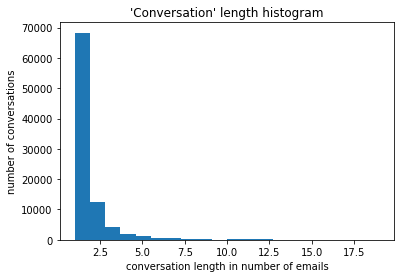

In [11]:
print("number of emails: ", len(headers_srtd))
print("number of extracted conversations: ", len(convos))

lens = list(map(len, convos))
print("mean, median and standard dev. of conversation length (in number of emails)\n", 
      round(np.mean(lens), 3), np.median(lens), round(np.var(lens)**.5, 3))

import matplotlib.pyplot as plt
plt.hist([l for l in lens if l < 20], bins=20)
plt.title("'Conversation' length histogram")
plt.xlabel("conversation length in number of emails")
plt.ylabel("number of conversations")
plt.show()